# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

# Task 1: Read the _hourly_ data and split into training and test data.

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import phik
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

hourly = pd.read_csv('./data/hour.csv')
daily = pd.read_csv('./data/day.csv')
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Glancing at the Non-Nulls, it looks that there are no NANs in the data, so this will not need to be explored in the EDA phase.

Before I split into train and test data, I'd like to rename the columns so the're clearer. This should most likely be done in Task 2 as part of EDA data pre-processing, but we can do it here so that our train and test data all use the same column names.

In [57]:
hourly.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'working_day', 'weathersit': 'weather_situation', 'atemp': 'feels-like-temp', 'hum': 'humidity', 'cnt': 'bike_count', 'weekday': 'day_of_week'}, inplace=True)
hourly.head(1)

,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed,casual,registered,bike_count
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16


In [58]:
from sklearn.model_selection import train_test_split

# Splitting features and targets
targets = hourly[['bike_count', 'registered', 'casual']]

features = hourly.drop(targets, axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(features, targets, test_size=0.2)
train_df = pd.merge(xtrain, ytrain, left_index=True, right_index=True) # using this to plot training data

xtrain.head(3)

,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed
796,797,2011-02-05,1,0,2,15,0,6,0,3,0.22,0.2727,1.00,0.0000
85,86,2011-01-04,1,0,1,17,0,2,1,1,0.28,0.2727,0.48,0.2239
1262,1263,2011-02-25,1,0,2,18,0,5,1,1,0.32,0.2879,0.49,0.4925


# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model
In order to structure the EDA in an appropriate manner, I will follow the same format followed in Assignment One and take the analysis in three passes:
<br>

 1. First pass - load data set and initial clean <br> <br>
 2. Second pass - individual features and target <br> <br>
 3. Third pass - relationships between features and target

In [59]:
print("Features: ", xtrain.columns.tolist()) ## the features in question

print("Targets: ", ytrain.columns.tolist()) ## the targets in question

Features:  ['instant', 'date', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']
Targets:  ['bike_count', 'registered', 'casual']


## Pass One

### Duplicates & NAs

In [60]:
print('Num of duplicates: {}'.format(train_df.duplicated().sum()))

Num of duplicates: 0


In [61]:
nullvalues = (train_df.isna().sum()/train_df.shape[0])*100
nullvalues # Percentage of missing values in columns

instant              0.0
date                 0.0
season               0.0
year                 0.0
month                0.0
hour                 0.0
holiday              0.0
day_of_week          0.0
working_day          0.0
weather_situation    0.0
temp                 0.0
feels-like-temp      0.0
humidity             0.0
windspeed            0.0
bike_count           0.0
registered           0.0
casual               0.0
dtype: float64

Since the dataset contains no missing or duplicate values, then there is no need to perform any additional cleaning or preprocessing steps. Also, the columns have already been renamed and are in a state now that we can begin to examine the data to learn more about it.

**Note**: Before I move onto pass two I would like to drop the **instant** feature since it is of no use to me!

In [62]:
xtrain.drop('instant', inplace=True, axis=1)
xtest.drop('instant', inplace=True, axis=1)
print("Features without Instant: ", xtrain.columns.tolist()) ## the features in question

Features without Instant:  ['date', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']


## Pass Two
To make pass two a bit easier I am going to examine the features in three groups.

- Date, Season, Year, Month, Hour, Holiday, Day of the Week and Working day can all fit under a category named **Calendar Information**
- Weather Situation, temperature, feels like temperature, humidity and windspeed can all fit under a category named **Weather Information**

### Calendar Information Features
To further simplify the EDA and put feature analysis into context, I'll group them as I see fit and perform multi-variate analysis immediately instead of performing single-variate analysis on every feature.

#### Features: Date, Year, & Holiday

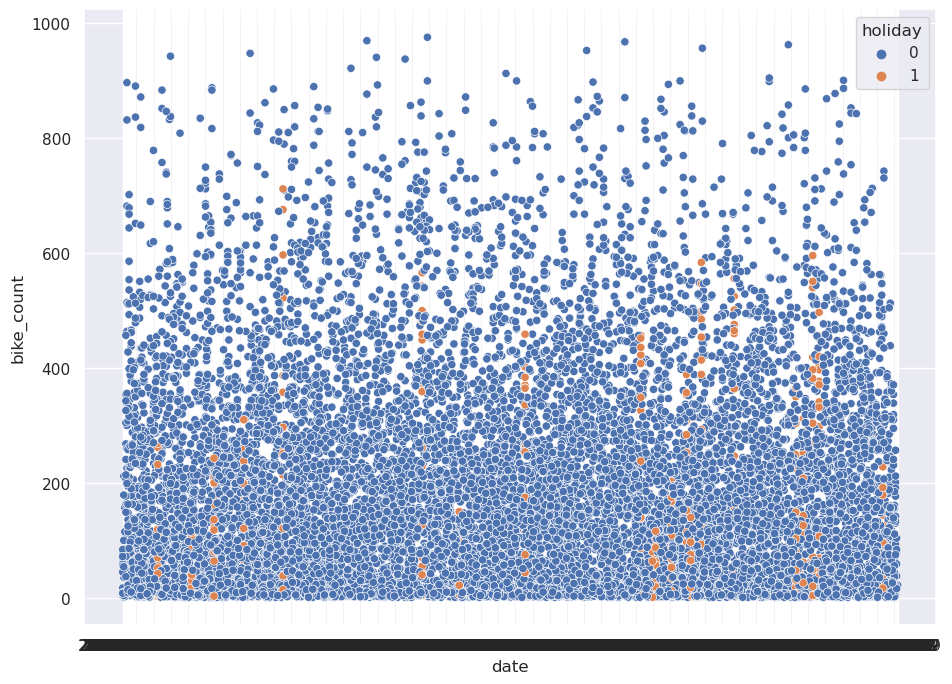

In [63]:
sns.scatterplot(x='date', y='bike_count', data=train_df, hue='holiday')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

From the above, we can see that during 2011, it looks there were a much smaller number of bicycles being rented per hour in total. We can also see that days that were holidays vs those that weren't were much lower. As a small conclusion from this scatter plot, we can derive 2012 had much more bikes being rented, the start of the year generally has a far lower number of bikes being rented which begins to rise around April. It also starts to drop off slightly again around October in both years.

As it is difficult to see the holiday details lets plot that alone.

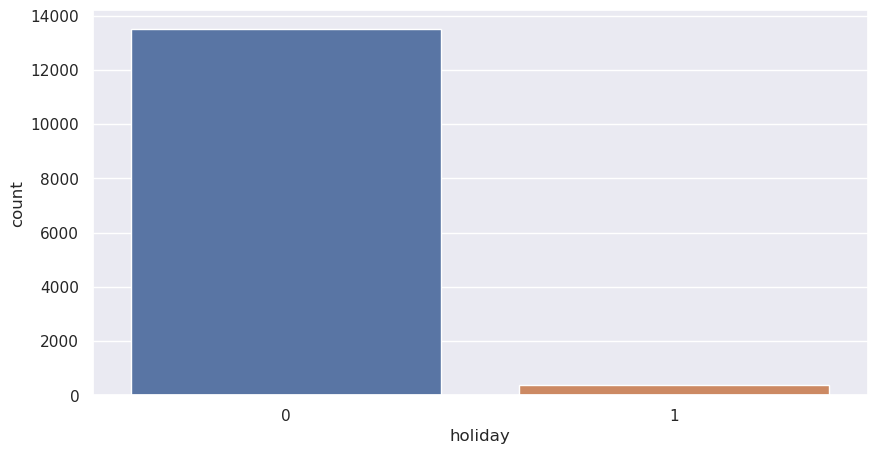

In [64]:
sns.countplot(x='holiday', data=train_df)
plt.rcParams['figure.figsize'] = [5, 2]
plt.show()

Clearly, we can see that the ratio of days that weren't holidays to days that were is very one-sided.

In [65]:
ytrain_holiday_1 = ytrain.loc[xtrain["holiday"] == 1]
average_bike_count_1 = ytrain_holiday_1["bike_count"].mean()
ytrain_holiday_0 = ytrain.loc[xtrain["holiday"] == 0]
average_bike_count_0 = ytrain_holiday_0["bike_count"].mean()

print(f'Average bike count when holiday == 0 is {average_bike_count_0} and average bike count when holiday == 1 is {average_bike_count_1}')

Average bike count when holiday == 0 is 189.74330522266607 and average bike count when holiday == 1 is 158.24935064935065


This skew wont aid us much as when it is not a holiday, more bikes are rented. While it could be a slightly good predictor, given that there are so few holidays we will probably drop this feature during the feature engineering section in Task 3.

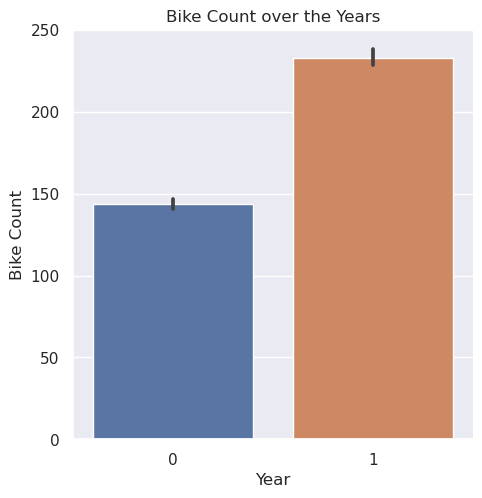

In [66]:
sns.catplot(x='year', y='bike_count', data=train_df, kind='bar')

plt.title("Bike Count over the Years")
plt.xlabel("Year")
plt.ylabel("Bike Count")
plt.show()

Again, the above barplot shows that more bikes can be seen to have been rented during 2012 when compared to 2011. This will likely be a good predictor. As Month, Date, Year, all kind of say the same thing and will likely be highly correlated in EDA pass 3, some of these will likely be dropped. I suspect I will drop date as it has too much information in one feature. Year can be kept as it seems to be a significant predictor and date and holiday will then be dropped!

#### Features: Season & Month
Season and Month are largely the same, where month has 12 options, season has 4 so I will most likely remove one of these but I'd like to see which would be the better predictor.

From the plot below, during each season it looks as though during Summer (3) the variance between each month is not that significant as to be expected. During the ther months though, within each season, the average hourly bikes rented varies quite a bit. This might mean that month could be a better choice. As an example to explain my thought process here - say there are two rows, both of which are in Spring (2) and one at the start and one at the end. With just season, we don't get a clear picture of average bike count. But if we can say the start of Spring we can expect far less than the end of Spring, this would provide much more valuable context. Thus, month is a better predictor.

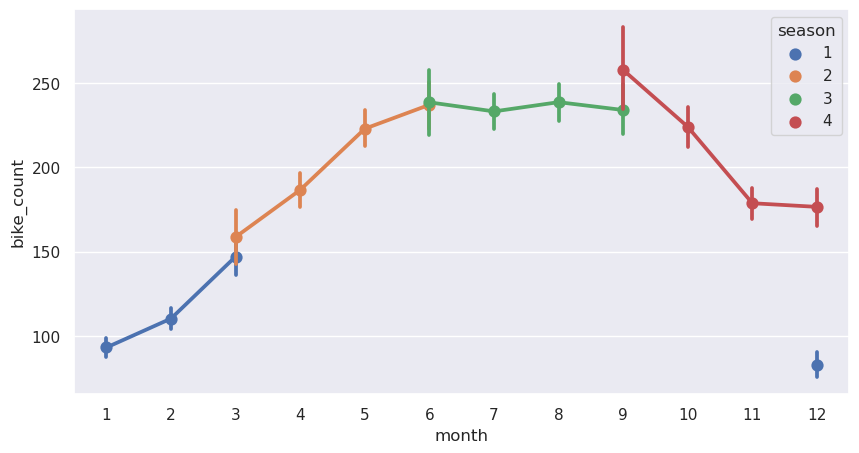

In [67]:
plt.figure(figsize=(10,5))
sns.pointplot(x="month", y="bike_count", hue="season", data=train_df)
plt.show()

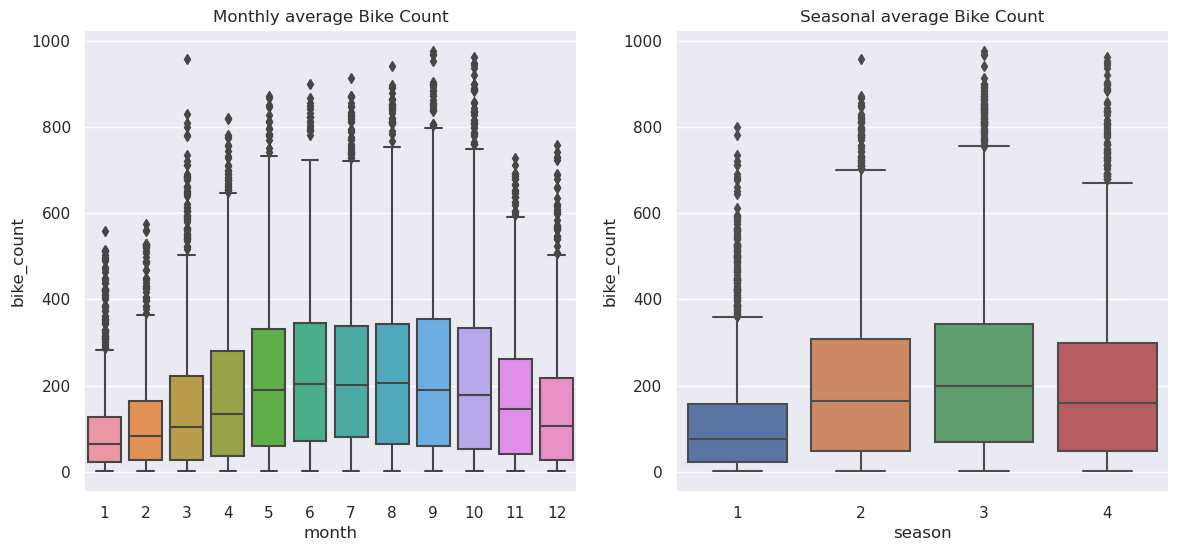

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x="month", y="bike_count", data=train_df, ax=ax1)
ax1.set_title('Monthly average Bike Count')

sns.boxplot(x="season", y="bike_count", data=train_df, ax=ax2)
ax2.set_title('Seasonal average Bike Count')

plt.show()

The above plot confirms what was discussed in the previous markdown cell. The right hand plot shows that the variance in bike count does not vary a lot during Spring Summer and Autumn but it does in Winter (expected as weather is worse in Winter). But with month we see a far more accurate picture where the average bike count gradually increases during the early months, peaks in summer, and starts to decline again as it approaches the end of the year.

After revisiting this at a later date.. I've decided that in order to avoid bias I am going to drop month instead of season, and split season into 4 separate features. This will allow me to say that summer is a great predictor but winter isnt, using them as separate features entirely.

#### Features: Day of The Week, Working day, & Hour

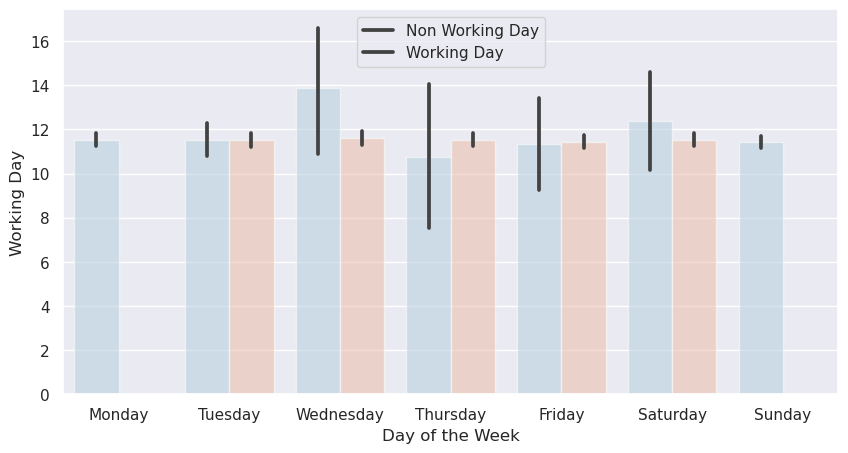

In [69]:
plt.figure(figsize=(10,5))
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x='day_of_week', y='hour', hue='working_day', data=train_df, palette='RdBu_r', alpha=0.5)
plt.xticks(range(7), days_of_the_week)
plt.legend(labels=['Non Working Day', 'Working Day'])
plt.xlabel("Day of the Week")
plt.ylabel('Working Day')
plt.show()

It appears that there are more bike rentals on weekdays (Monday through Friday) than on weekends (Saturday and Sunday). This could be because people are more likely to use a bike for commuting on weekdays, while they may be more likely to use a car or public transportation on weekends.

One interesting insight that can be derived from the plot is that there is a spike in bike rentals on Thursday and Friday. This could be because people are more likely to use a bike for leisure activities on the weekends, and so they may rent a bike on Thursday or Friday to use for the weekend.

Due to working day being quite redundant with the present of day of the week, I will drop that. Also, I am going to split day of the week into separate features to reduce bias as friday could be a great predictor for the targets but the other days might not!

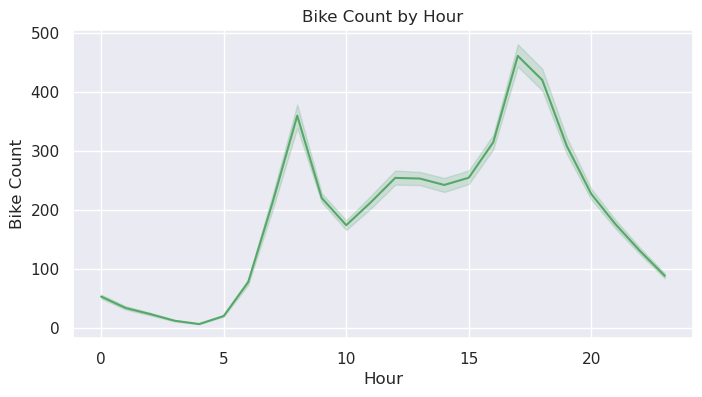

In [70]:
plt.figure(figsize=(8,4))
sns.lineplot(x="hour", y="bike_count", data=train_df, color='g')

plt.title("Bike Count by Hour")
plt.xlabel("Hour")
plt.ylabel("Bike Count")

plt.show()

The plot shows that the number of bike rentals is highest during the morning and evening hours, when people are likely to use a bike for commuting to and from work. The plot also shows spikes in bike rentals during the middle of the day and late afternoon, indicating that people may be using bikes for leisure activities during these times. Additionally, the plot shows that the number of bike rentals is highest during the early morning hours, around 7-8am, and the late afternoon hours, around 5-6pm, suggesting that people are using bikes for commuting during these times. It is likely that this feature will prove to be a good predictor.

### Weather Information Features

#### Features: Temperature & Feels like Temperature,

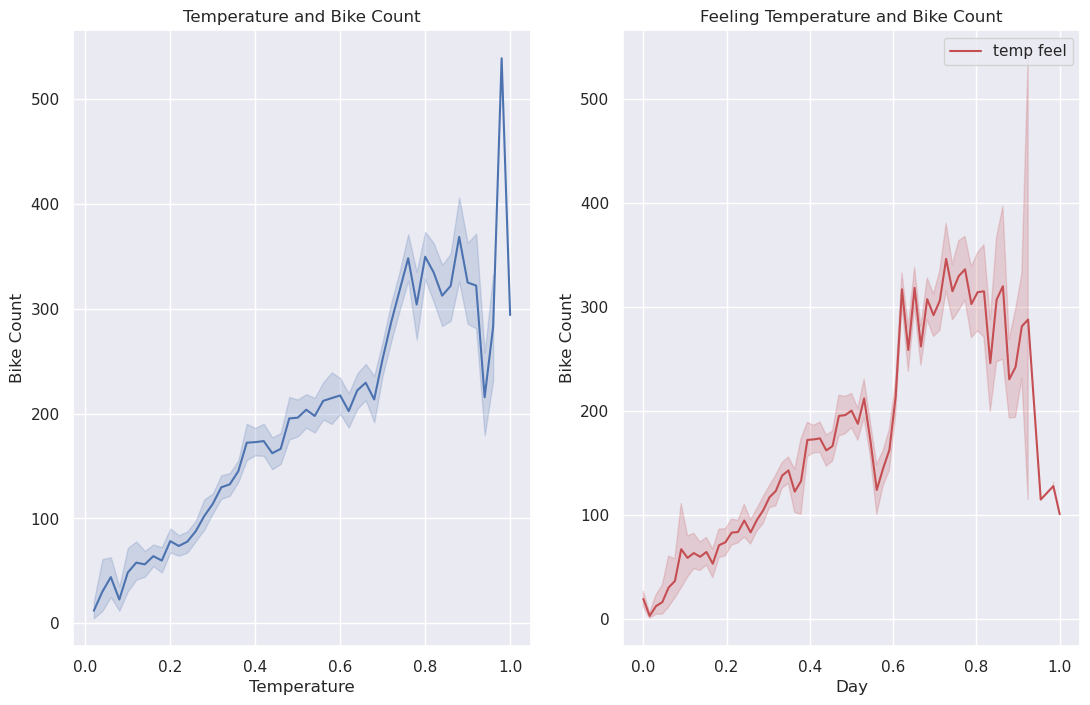

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.lineplot(x='temp', y='bike_count', data=train_df, ax=ax[0])
ax[0].set_xlabel('Temperature')
ax[0].set_ylabel('Bike Count')
ax[0].set_title('Temperature and Bike Count')

# plot atemp and bike count on one plot
sns.lineplot(x='feels-like-temp', y='bike_count', data=train_df, label='temp feel', color='r', ax=ax[1])
ax[1].set_title('Feeling Temperature and Bike Count')
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Bike Count')

plt.show()

These features are fairly self explanatory. The normalised actual and feeling temperatures. As the graphs above suggest, the lower temperatures tend to have far less people hiring bikes. The higher temperatures have more but there's a steep drop off near the high end of the graphs. There will be no need to keep two of these features as they are clearly closely related and likely highly correlated. I will actually drop the temperature (not atemp, or now feels-like-temp) as the feels like temp will be more of an indication of whether people will rent bikes as it is what people feel and people tend to act on feelings instead of the temperature. This will likely also be a strong predictor.

#### Features: Weather Situation, Humidity, & Windspeed

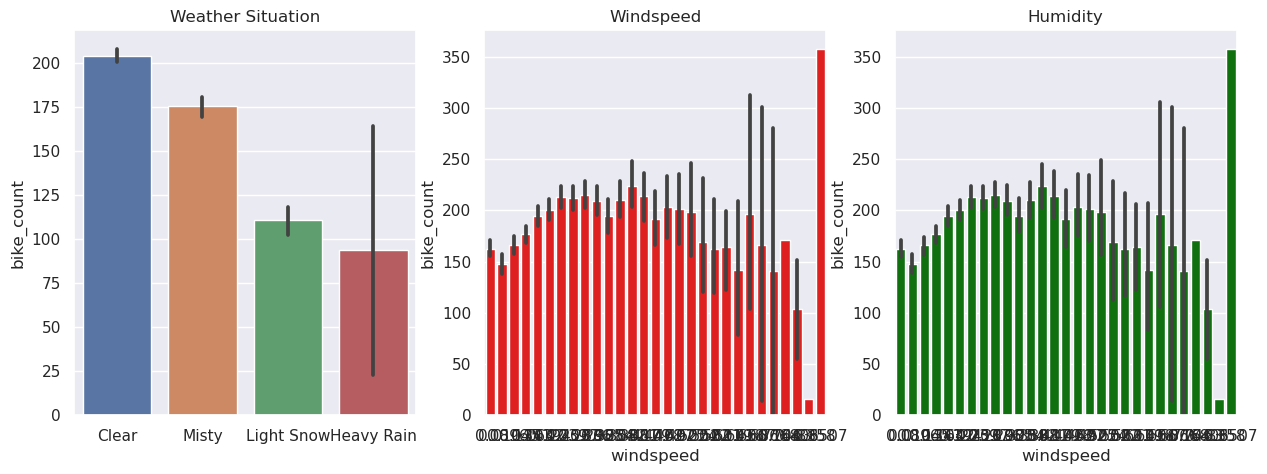

In [72]:
# Setting up the figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

labels = ['Clear', 'Misty', 'Light Snow', 'Heavy Rain']

# Plot #1: Weather Situation
sns.barplot(data=train_df, x='weather_situation', y='bike_count', ax=ax1)
ax1.set_title('Weather Situation')
ax1.set_xticks(range(4), labels)
ax1.set_xlabel("")

# Plot #2: Windspeed
sns.barplot(data=train_df, x='windspeed', y='bike_count', ax=ax2,color="red")
ax2.set_title('Windspeed')

# Plot #3: Humidity
sns.barplot(data=train_df, x='windspeed', y='bike_count', ax=ax3, color="green")
ax3.set_title('Humidity')

plt.show()

From the above we can derive the following insights:
- The weather situation has some clear indication of the number of bike rentals. Light snow and heavy rain have far less bike rentals than misty and clear weather
- The windspeed and humidity data is quite sporadic and difficult to interpret from these plots so lets do some further examination.

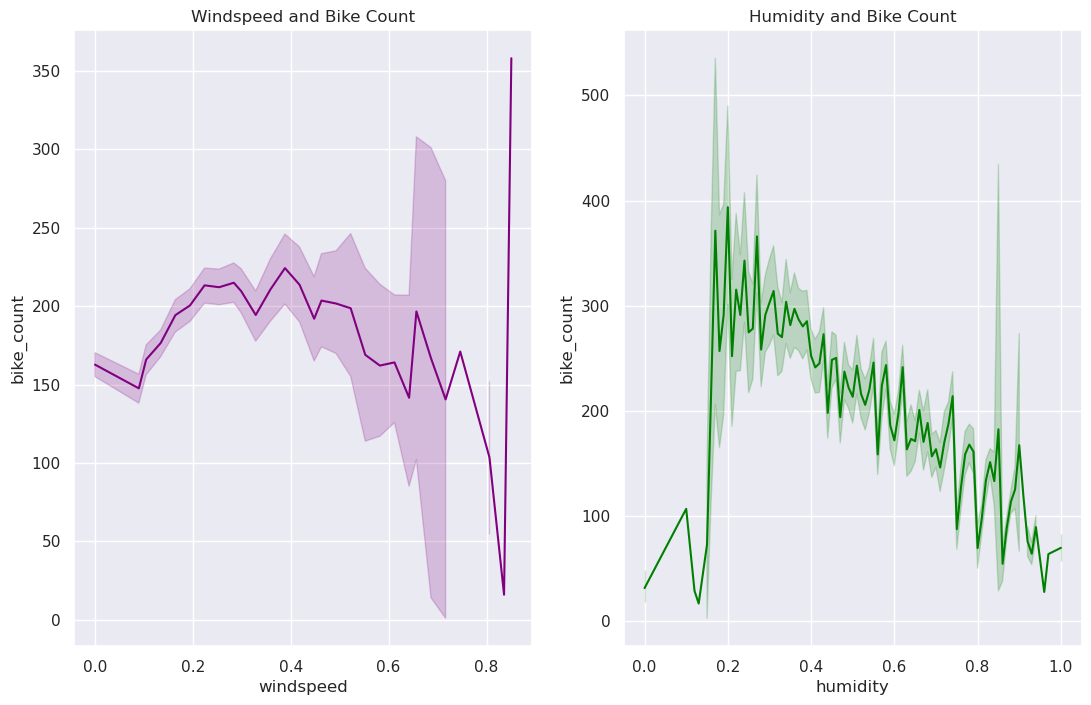

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.lineplot(x='windspeed', y='bike_count', data=train_df, ax=ax[0], color='purple')
ax[0].set_title('Windspeed and Bike Count')

sns.lineplot(x='humidity', y='bike_count', data=train_df, color='green', ax=ax[1])
ax[1].set_title('Humidity and Bike Count')

plt.show()

I would suspect there to be some outliers present from how the data looks here. But, for the case of humidity: the number of bikes being rented significantly decreases the higher the level of humidity gets. The same can most likely be said for windspeed, although I would say the spike on the right hand side of that graph could be due to outliers. I will check.

<AxesSubplot:xlabel='windspeed'>

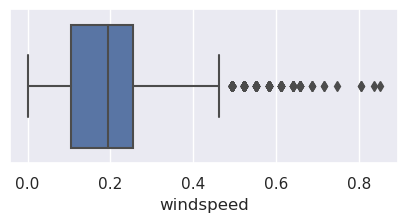

In [74]:
sns.boxplot(data=train_df, x="windspeed")

Definitely some outliers present here, since I think it does negatively affect the data, I could use log transformation or another method later to deal with them (during feature engineering).

That marks the end of pass two, onto pass 3.

## Pass Three

interval columns not set, guessing: ['instant', 'season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed', 'bike_count', 'registered', 'casual']


,instant,date,season,year,month,hour,holiday,day_of_week,working_day,weather_situation,temp,feels-like-temp,humidity,windspeed,bike_count,registered,casual
instant,1.000000,0.443347,0.806566,0.625402,0.795744,-0.329894,-0.047486,-0.245119,-0.242811,0.054556,0.743705,0.736880,0.220750,0.115608,0.152381,0.108370,0.159599
date,0.443347,1.000000,0.397516,0.207087,0.405443,-0.898510,0.374278,0.322834,0.311101,0.052027,0.203589,0.203744,-0.142626,-0.107067,-0.635193,-0.652467,-0.363841
season,0.806566,0.397516,1.000000,0.272453,0.994058,-0.306036,0.103450,-0.097517,-0.085005,0.158451,0.902789,0.902788,0.294522,0.240512,0.076895,0.023176,0.228100
year,0.625402,0.207087,0.272453,1.000000,0.251557,-0.189630,0.156176,0.065398,0.056322,0.164830,0.232302,0.224781,0.251384,0.110587,0.253036,0.261201,0.183978
month,0.795744,0.405443,0.994058,0.251557,1.000000,-0.276244,0.095233,-0.112163,-0.098638,0.146830,0.923728,0.925935,0.333062,0.250784,0.089495,0.030576,0.248119
hour,-0.329894,-0.898510,-0.306036,-0.189630,-0.276244,1.000000,-0.411710,-0.333895,-0.312080,-0.129403,-0.006183,-0.008000,0.301482,0.047021,0.785209,0.780343,0.567934
holiday,-0.047486,0.374278,0.103450,0.156176,0.095233,-0.411710,1.000000,0.620647,0.657688,0.158185,-0.016375,-0.019833,0.018027,0.055715,-0.295551,-0.274246,-0.091305
day_of_week,-0.245119,0.322834,-0.097517,0.065398,-0.112163,-0.333895,0.620647,1.000000,0.980102,0.132383,-0.136410,-0.144841,-0.022702,-0.014734,-0.236251,-0.194962,0.140040
working_day,-0.242811,0.311101,-0.085005,0.056322,-0.098638,-0.312080,0.657688,0.980102,1.000000,0.091515,-0.131838,-0.142117,-0.076668,-0.076655,-0.177271,-0.140256,0.220973
weather_situation,0.054556,0.052027,0.158451,0.164830,0.146830,-0.129403,0.158185,0.132383,0.091515,1.000000,0.125501,0.143649,0.613804,0.192031,-0.077557,-0.100515,-0.018158


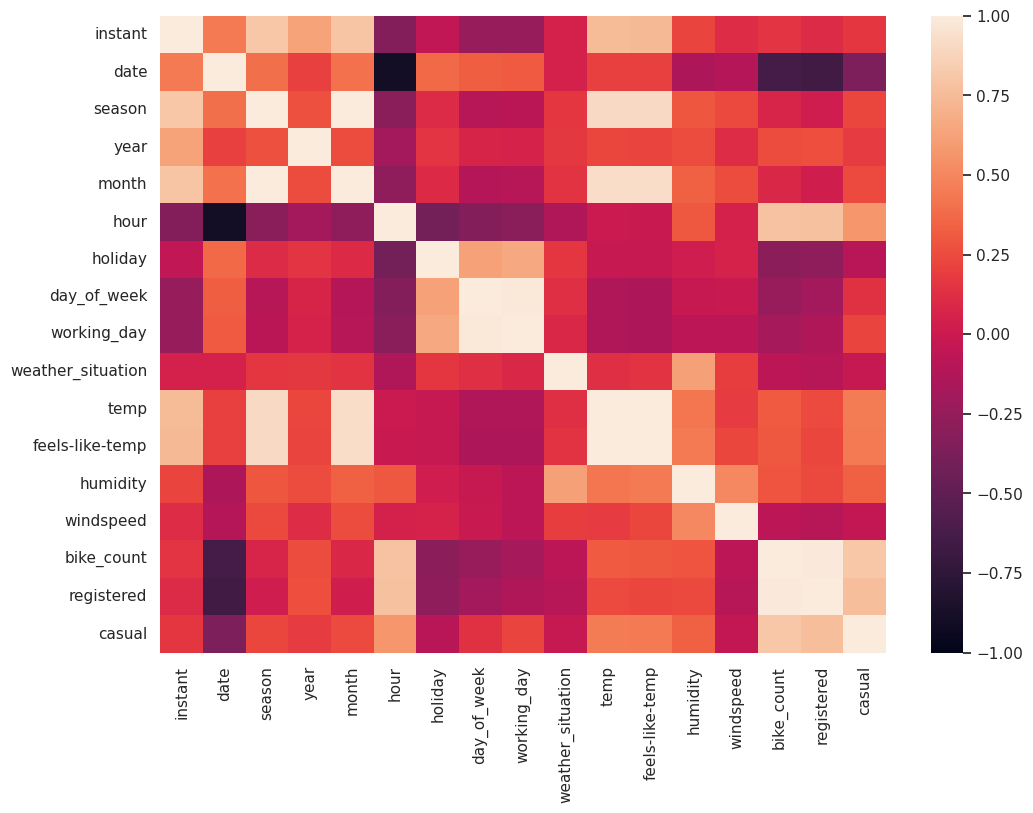

In [75]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
correlation_dataframe = phik.phik_matrix(df=train_df)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=False)
correlation_dataframe.corr()

To make EDA pass 3 a bit quicker, as I've already identified what I will most likely drop in feature engineering, I will give an overview of which features are highly correlated to which targets. This may give a better indication of what features should be dropped. ie. if two features are highly correlated with each other and there is a question of which one to drop, if one is significantly more correlated to the targets then that one should be kept. Below is a table of how correlated the features are to the targets. Lets examine this: (This was extracted from the phik matrix above)

|                       | **Bike Count** | **Registered** | **Casual** |
|:---------------------:|:--------------:|:--------------:|:----------:|
|        **date**       |    -0.627730   |    -0.639281   |  -0.359281 |
|       **season**      |    0.059453    |    0.012389    |  0.214637  |
|        **year**       |    0.268499    |    0.282824    |  0.196046  |
|       **month**       |    0.072982    |    0.020882    |  0.236883  |
|        **hour**       |    0.783824    |    0.774363    |  0.570063  |
|      **holiday**      |    -0.290288   |    -0.265950   |  -0.082216 |
|    **day_of_week**    |    -0.219941   |    -0.173733   |  0.147496  |
|    **working_day**    |    -0.170971   |    -0.129386   |  0.221224  |
| **weather_situation** |    -0.069441   |    -0.089405   |  -0.015186 |
|        **temp**       |    0.296841    |    0.236068    |  0.436657  |
|  **feels-like-temp**  |    0.287566    |    0.225315    |  0.429462  |
|      **humidity**     |    0.291050    |    0.254055    |  0.343017  |
|     **windspeed**     |    -0.071777   |    -0.094068   |  -0.046066 |

There actually looks to be few extremely high correlations between targets and features. Below are the few highly correlated features and targets
- Date is highly correlated with Bike count and registered
- Hour is highly correlated with all three targets

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

## Feature Engineering
Now we need to perform some feature engineering to increase the performance of the model to be created
First, some features need to be dropped to remove correlation. We can revisit the matrix but with the xtrain data only to view this.

interval columns not set, guessing: ['season', 'year', 'month', 'hour', 'holiday', 'day_of_week', 'working_day', 'weather_situation', 'temp', 'feels-like-temp', 'humidity', 'windspeed']


<AxesSubplot:>

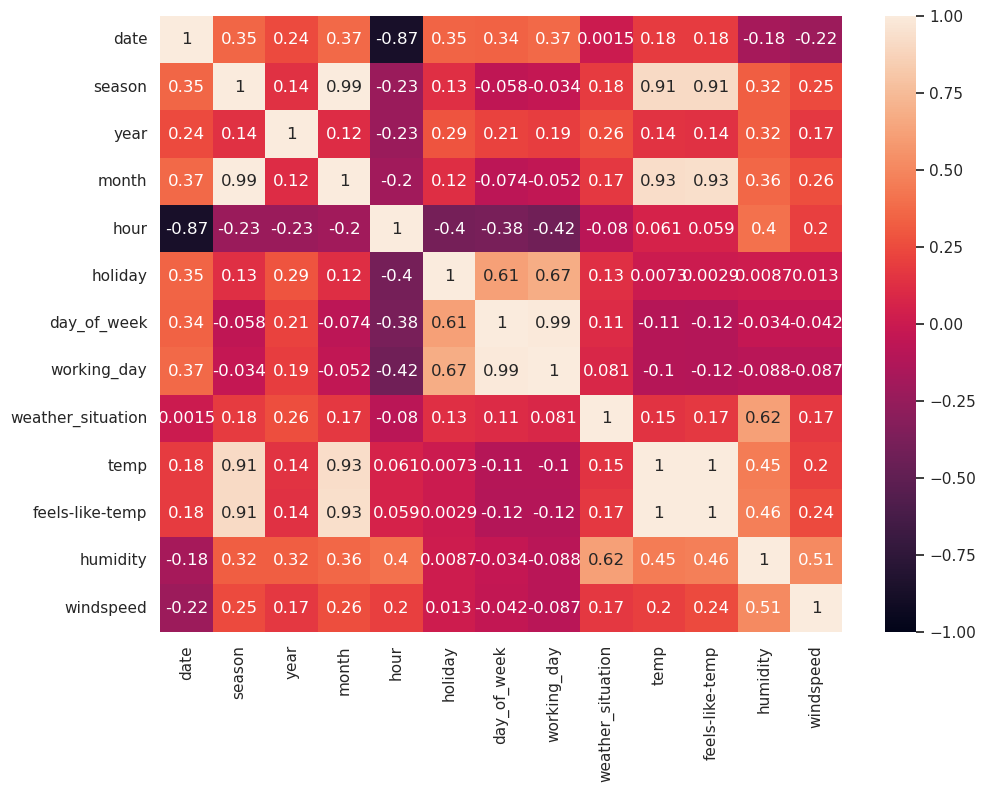

In [76]:
sns.set(rc={'figure.figsize':(11, 8)})
correlation_dataframe = phik.phik_matrix(df=xtrain)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=True)

We can clearly see that some features are highly correlated with each other. Ideally we'd like to remove this as part of the feature engineering. First, I'll recap on the features we marked for removal during EDA.
- Holiday
- Month
- Workingday

### Highly Correlated Features
- Date and Hour.
    - The data from date is quite sporadic and not refined enough. We can also derive the same information using day of the wee, year and month so date can be dropped
- Season with Month, temp and atemo.
    - Since we have already decided to drop month, that isn't an issue. I will likely drop temp as discussed in the eda as feels like temp seems to me to be a better option.
- Year is not highly correlated with anything so that can be kept!
- Month is highly correlated with (besides season) the two temp features. I will be removing feels-like-temp and will wait until I convert season to separate features.
- Weather situation is highly correlated with humidity, we will need to deal with this.
- There are other correlations but first I would like to drop the unneeded and split up the days of the week and seasons!

In [77]:
xtrain.drop(columns=['holiday', 'month', 'working_day' , 'temp', 'date'], inplace=True)
xtest.drop(columns=['holiday', 'month', 'working_day' , 'temp', 'date'], inplace=True)

### Transforming Features
Next I want to split season and day_of_week up. This can be done using the pandas get_dummies function.

#### Season
I'm going to use the below example row to test that this works correctly. I can't define exactly what the season value is here as every time this notebook is run, the train data is going to be different. I was originally running xtrain.loc[0] but oftentimes once I ran the notebook again 0 wasnt included in the training data. So here is a sample below chosen randomly. This value will need to be resassigned after changing the data frame.

In [78]:
eg = xtrain.sample()
eg

,season,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed
8863,1,1,4,2,2,0.2121,0.86,0.1642


In [79]:
season_dummies = pd.get_dummies(xtrain["season"]) # Create 4 new columns from the possible values
season_dummies.columns = ["spring", "summer", "autumn", "winter"] # rename those new columns

xtrain = xtrain.join(season_dummies)

season_dummies = pd.get_dummies(xtest["season"]) # Create 4 new columns from the possible values
season_dummies.columns = ["spring", "summer", "autumn", "winter"] # rename those new columns

xtest = xtest.join(season_dummies)

In [80]:
eg = xtrain.loc[eg.index]
eg

,season,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed,spring,summer,autumn,winter
8863,1,1,4,2,2,0.2121,0.86,0.1642,1,0,0,0


Spring has a value of 1 and the rest are 0 so it worked. Now to drop the old season column and do the same for day_of_week!

In [81]:
xtrain.drop(['season'], inplace=True, axis=1)
xtest.drop(['season'], inplace=True, axis=1)

In [82]:
xtrain.day_of_week.unique()

array([6, 2, 5, 4, 0, 3, 1])

#### Day of Week
Again, I'll use thew same row as seen above and will test that it has worked after splitting the feature.

In [83]:
dow_dummies = pd.get_dummies(xtrain["day_of_week"]) # Create 7 new columns from the possible values
dow_dummies.columns = ["sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday"] # rename those new columns

xtrain = xtrain.join(dow_dummies)

dow_dummies = pd.get_dummies(xtest['day_of_week']) # Create 7 new columns from the possible values
dow_dummies.columns = ["sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday"] # rename those new columns

xtest = xtest.join(dow_dummies)

In [84]:
eg = xtrain.loc[eg.index]
eg

,year,hour,day_of_week,weather_situation,feels-like-temp,humidity,windspeed,spring,summer,autumn,winter,sunday,monday,tuesday,wednesday,thursday,friday,saturday
8863,1,4,2,2,0.2121,0.86,0.1642,1,0,0,0,0,0,1,0,0,0,0


Looks like it was successful! Now we can drop the day_of_week feature and reexamine correlations.

In [85]:
xtrain.drop(['day_of_week'], inplace=True, axis=1)
xtest.drop(['day_of_week'], inplace=True, axis=1)

interval columns not set, guessing: ['year', 'hour', 'weather_situation', 'feels-like-temp', 'humidity', 'windspeed', 'spring', 'summer', 'autumn', 'winter', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']


<AxesSubplot:>

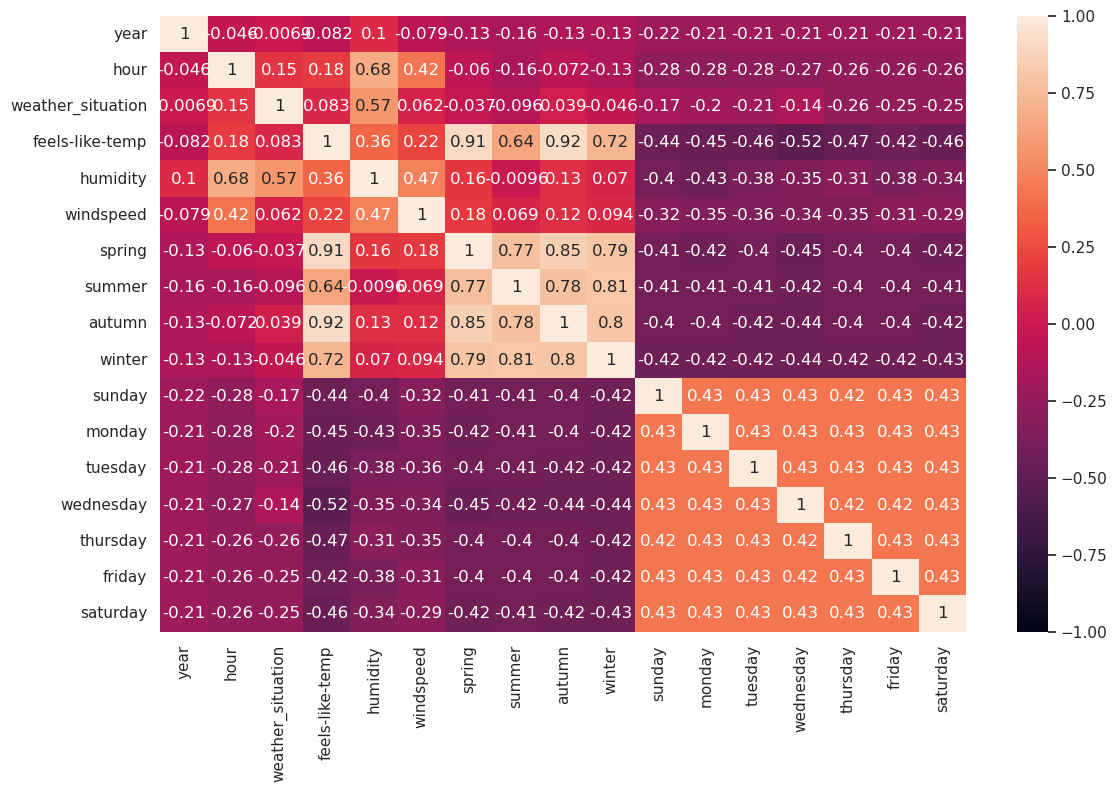

In [86]:
train_df = pd.merge(xtrain, ytrain, left_index=True, right_index=True) # using this to plot training data

plt.figure(figsize=(13, 8))
correlation_dataframe = phik.phik_matrix(df=xtrain)
sns.heatmap(correlation_dataframe.corr(), vmin=-1, vmax=1, annot=True)

Lets examine the above:
- Humidity has high correlation with two other features so lets drop that.
- Feels like temp has high correlation with all seasons. I don't want to remove any just yet, but using forward select I will examine what would be best to keep, for now they can stay.
- None of the days of the week have high correlation with anything which is good. Feels like temp is on the brim of high correlation (0.5) with wednesday.

In [87]:
xtrain.drop(['humidity'], inplace=True, axis=1)
xtest.drop(['humidity'], inplace=True, axis=1)

## Target Examination
I ran into a lot of issues while trying to deal with the targets. One of which was when I was trying to log transform them as seen below, it was running into issues. This is because log transforming a zero value results in an -inf outcome. This was causing trouble when trying to calculate prediction scores.

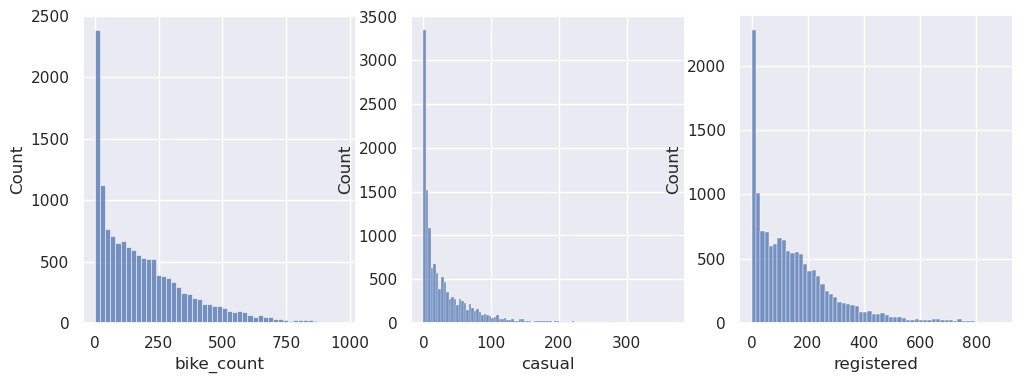

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(data=ytrain, x='bike_count', ax=ax[0])
sns.histplot(data=ytrain, x='casual', ax=ax[1])
sns.histplot(data=ytrain, x='registered', ax=ax[2])

plt.show()

Our targets are clearly all skewed to the left. This is not good as building a model with skewed targets can lead to bias. The model can be very accurate at predicting the value in the skewed direction (so good at predicting when bike count, number of casual riders, and number of registered riders is low) and will be inaccurate at predicting the opposite skew direction. To fix thos, we need to normalise the targets. We can use a number of methods, but here we can use log transform. Log transformation works by applying a logarithmic function to each value in the dataset, replacing that value by its logarithm, according to the base of the log func being used. This will normalize our targets before we use forward selection!

In [89]:
# Need to deal with new nans and negative inf values which are now present after transformation
ytrain.replace([np.inf, -np.inf], np.nan, inplace=True)
ytrain['bike_count'].fillna(ytrain['bike_count'].mean(), inplace=True)
ytrain['registered'].fillna(ytrain['registered'].mean(), inplace=True)
ytrain['casual'].fillna(ytrain['casual'].mean(), inplace=True)

Using Log transform below, adding +1 as performing log transformation on a zero value will result in -inf values.

In [90]:
ytrain['bike_count'] = np.log(ytrain['bike_count'] + 1)
ytrain['registered'] = np.log(ytrain['registered'] + 1)
ytrain['casual'] = np.log(ytrain['casual'] + 1)

Now that they have been log transfored, we can plot them to ensure they aren't as skewed.

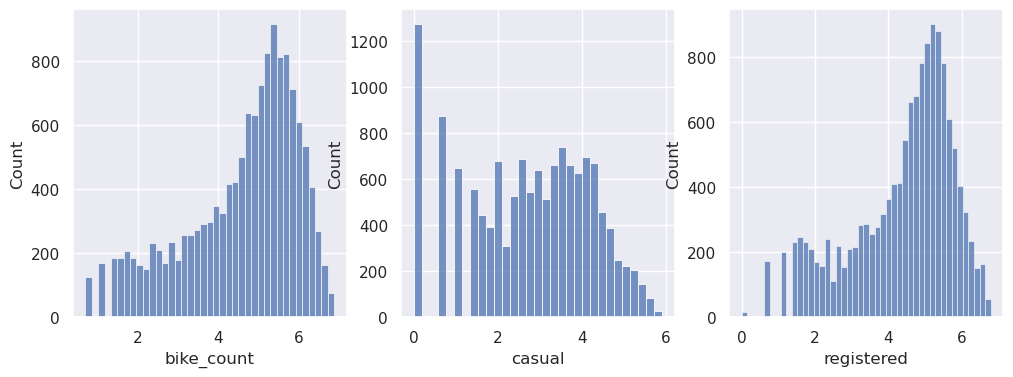

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(data=ytrain, x='bike_count', ax=ax[0])
sns.histplot(data=ytrain, x='casual', ax=ax[1])
sns.histplot(data=ytrain, x='registered', ax=ax[2])

plt.show()

Great. We can now use the code provided by credit balance lab to run through all of the targets and features to find the best predictors for each target.

### Forward Selection
Forward selection is a feature selection method that starts with an empty set of features and adds features to the set one at a time, based on some evaluation criterion, until the desired level of performance is reached. This process is repeated until all features have been added to the set and the performance is at its maximum. Since there is a larger number of features here, we can complete this task with the use of code.

In [92]:
model = linear_model.LinearRegression()

In [93]:
def find_next_best_predictor(X, found_predictors, column):
    all_predictors = list(X)
    predictors_to_search = set(all_predictors) - set(found_predictors)
    max_score = 0

    for predictor in predictors_to_search:
        trial_predictors = set(found_predictors)
        trial_predictors.add(predictor)
        x_col_subset = X.loc[:,list(trial_predictors)]
        model.fit(x_col_subset, column)
        current_score = model.score(x_col_subset, column)

        if current_score > max_score:
            max_score = current_score
            new_best_predictor_found = predictor

    return max_score, new_best_predictor_found


def predict_scores(predict_features, target):
    np = predict_features.shape[1]
    new_scores = [0]
    new_found_predictors = list()
    for i in range(np):
        (new_score, new_best_predictor_found) = find_next_best_predictor(predict_features, new_found_predictors, target)
        new_found_predictors.append(new_best_predictor_found)
        new_scores.append(new_score)

    print(new_found_predictors)
    print(new_scores)
    return new_scores

The above functions will find the best predictors in order for each target inputted.
The below code runs through each target column, calculates the best predictors, and print the values. Lastly it plots a line for each target. This will help us decide which target will be easiest to predict.

['hour', 'feels-like-temp', 'year', 'winter', 'weather_situation', 'windspeed', 'autumn', 'friday', 'saturday', 'thursday', 'sunday', 'spring', 'monday', 'wednesday', 'tuesday', 'summer']
[0, 0.31857929323399603, 0.4179215615260198, 0.4431480555360673, 0.4544048646036357, 0.4609546856360113, 0.4672010052719394, 0.46902327850064196, 0.46983222851503637, 0.47076028928601266, 0.47091424248251723, 0.471098766610216, 0.471152972913639, 0.4711931871936911, 0.47119427318036744, 0.47119427318036733, 0.47119427318036733]
['hour', 'feels-like-temp', 'year', 'winter', 'windspeed', 'weather_situation', 'friday', 'autumn', 'sunday', 'thursday', 'wednesday', 'saturday', 'spring', 'monday', 'tuesday', 'summer']
[0, 0.32102195078069995, 0.3950633169415886, 0.4244438122913171, 0.43710881517620803, 0.4425426832252274, 0.44802503799949767, 0.4493235158411385, 0.4502799974957039, 0.45099050244990024, 0.45134460735405624, 0.4513707913916475, 0.45139428371522416, 0.4514032861259031, 0.45140480815755324, 0.4

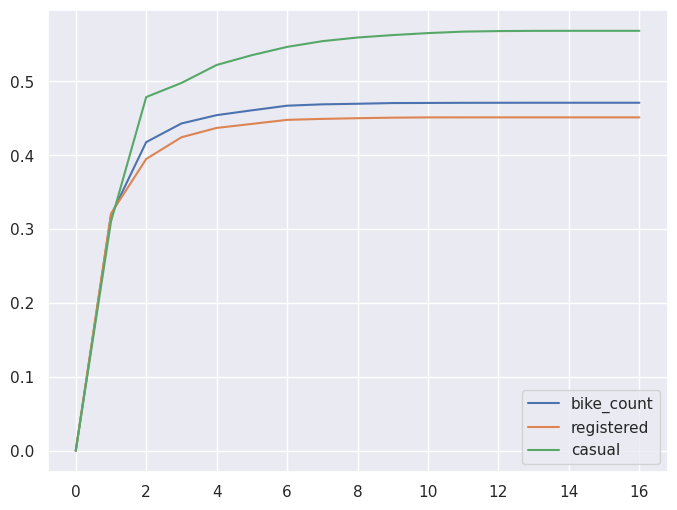

In [94]:
plt.figure(figsize=(8, 6))

for col in ytrain.columns:
    # Convert the column to a numeric array
    col_values = ytrain[col].values
    scores = predict_scores(xtrain, col_values)
    plt.plot(scores)

labels = ytrain.columns
plt.legend(labels)

From the three above, the features we could definitely keep as they are the strongest predictors are hour, feels-like-temp, year. It is generally a good idea to remove any columns that are not useful for making predictions before fitting a machine learning model. This can help to improve the performance of the model. However, in some cases, it might be useful to wait until after fitting the model to determine which columns are not useful for making predictions. For example, if using a regularization method such as Lasso or Ridge regression, the model will automatically identify and remove the columns that are not useful for making predictions. In this case, it might be best to wait until after fitting the model to remove the unnecessary columns, as this can make the model more interpretable and help you understand which columns are most important for making predictions.

### Scaling and Regression Models
After forward selection, it is common to scale the data before training a model on the selected features. This is because many machine learning algorithms, including linear regression, require that the features have similar scales in order to work properly.


If the scales of the features are very different, then some features may dominate the others during training, leading to poor model performance. For example, if one feature has values in the range 0 to 1, and another feature has values in the range 0 to 100,000, then the second feature will dominate the first feature during training, and the model may not be able to learn useful patterns from the first feature. I would also like to try a couple of different types of scalers to see which one performs the best!

#### Standardization
Standardization scaling is often recommended for regression methods that use regularization, such as ridge regression and lasso regression. This is because standardization scaling can help to ensure that the features are on the same scale, which can improve the performance of the regularization term and prevent the model from being overly sensitive to the magnitude of the coefficients. We can test this method of scaling in conjunction with those two types of regression.

This method scales the features by subtracting the mean of the feature and dividing by the standard deviation, so that the resulting distribution has a mean of 0 and a standard deviation of We'll do this for both the training and the testing data as using just the training data can be misleading

In [95]:
from sklearn.preprocessing import StandardScaler

# Transform the xtrain and xtest data using the scaler (fitting it to xtrain)
standard_scaler = StandardScaler()
xtrain_standard_scaled = standard_scaler.fit_transform(xtrain)
xtest_standard_scaled = standard_scaler.transform(xtest)

# Convert the scaled data back to dataframes
xtrain_scaled_df = pd.DataFrame(xtrain_standard_scaled, index=xtrain.index, columns=xtrain.columns)
xtest_scaled_df = pd.DataFrame(xtest_standard_scaled, index=xtest.index, columns=xtest.columns)

The negative coefficients in the model indicate that the features with negative coefficients have a negative relationship with the targets. In other words, as the values of the features with negative coefficients increase, the values of the targets are likely to decrease. This is not necessarily a problem, and it may be expected given the structure of the data and the relationships between the features and targets.

However, if the negative coefficients are causing the model to make poor predictions, this could indicate that the model is not well-suited to the data. In this case, we could try scaling the data using a different method to see if these changes improve the performance of the model. We could also try using cross-validation to evaluate the performance of the model and see if the negative coefficients are causing the model to make poor predictions on the validation set. This can help to identify any problems with the model and determine the best way to improve its performance.

**NOTE**: The scale of the yaxis in the plot below is a little wrong, but conveys the data nonetheless.

BIKE_COUNT 
 weather_situation   -0.117435
autumn              -0.094939
tuesday             -0.026239
spring              -0.025537
wednesday           -0.024265
monday              -0.015110
summer              -0.009866
sunday              -0.001461
thursday             0.001538
saturday             0.030503
friday               0.034662
windspeed            0.109011
winter               0.132446
year                 0.222743
feels-like-temp      0.512791
hour                 0.715372
dtype: float64 

REGISTERED 
 weather_situation   -0.106065
autumn              -0.081783
sunday              -0.038730
spring              -0.028927
summer              -0.022810
monday              -0.011875
tuesday             -0.009592
saturday            -0.003241
wednesday           -0.000501
thursday             0.020967
friday               0.043338
windspeed            0.104722
winter               0.135538
year                 0.237717
feels-like-temp      0.434866
hour                 0.7184

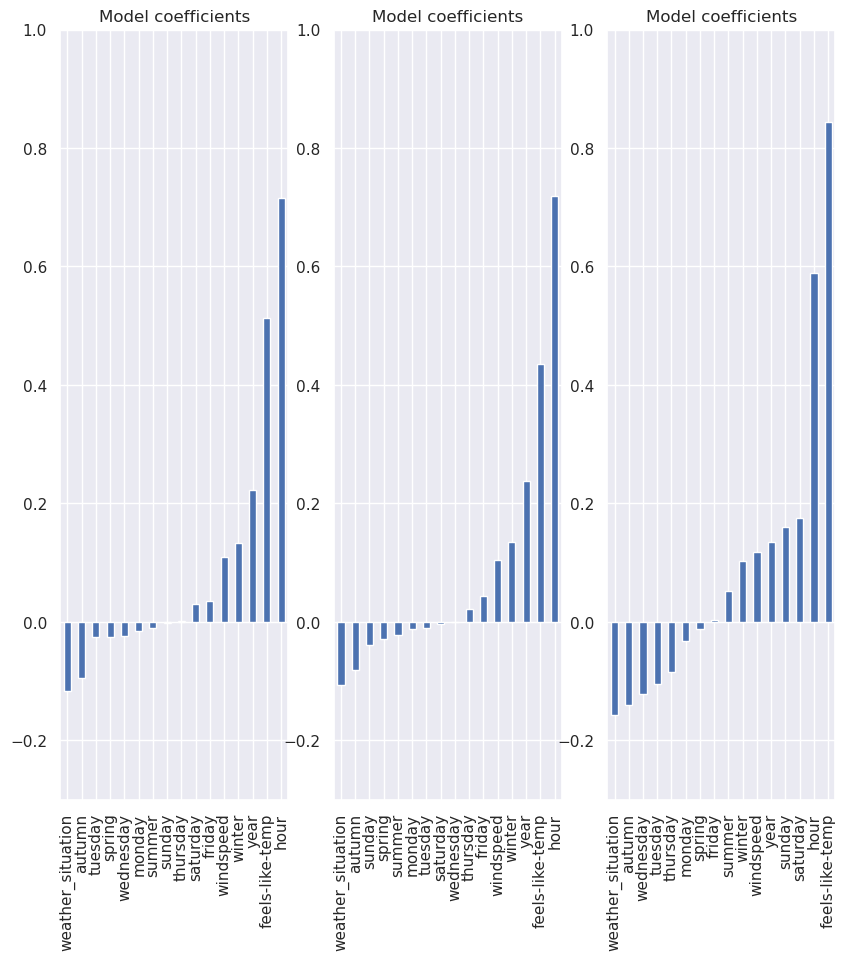

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytrain.columns):
    ax[i].set_ylim(bottom=-0.3) # Needed to set a limit on the negative values so that it is possible to view the positive values.
    col_values = ytrain[col].values
    model.fit(xtrain_scaled_df, col_values)

    predictors = xtrain_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

The plot shows that many of the predictors have negative coefficients, which indicates that they have a negative relationship with the target variable. This means that an increase in these predictors would lead to a decrease in the target variable.

To contrast, the test data shows a truer picture below.

BIKE_COUNT 
 weather_situation   -18.361657
autumn              -10.712613
monday               -5.552355
spring               -4.074998
sunday               -3.453516
thursday             -1.246940
tuesday               0.060088
saturday              1.769457
summer                1.822249
friday                3.752617
wednesday             4.694032
winter               13.166337
windspeed            15.406902
year                 45.526230
hour                 61.101492
feels-like-temp      68.860065
dtype: float64 

REGISTERED 
 weather_situation   -13.546350
sunday              -11.693638
saturday             -7.737103
autumn               -6.224584
spring               -5.545377
monday               -2.473928
summer                0.364968
thursday              3.450559
tuesday               4.819250
friday                5.138079
wednesday             8.700477
windspeed            10.432664
winter               11.537647
year                 39.019217
feels-like-temp      42.976

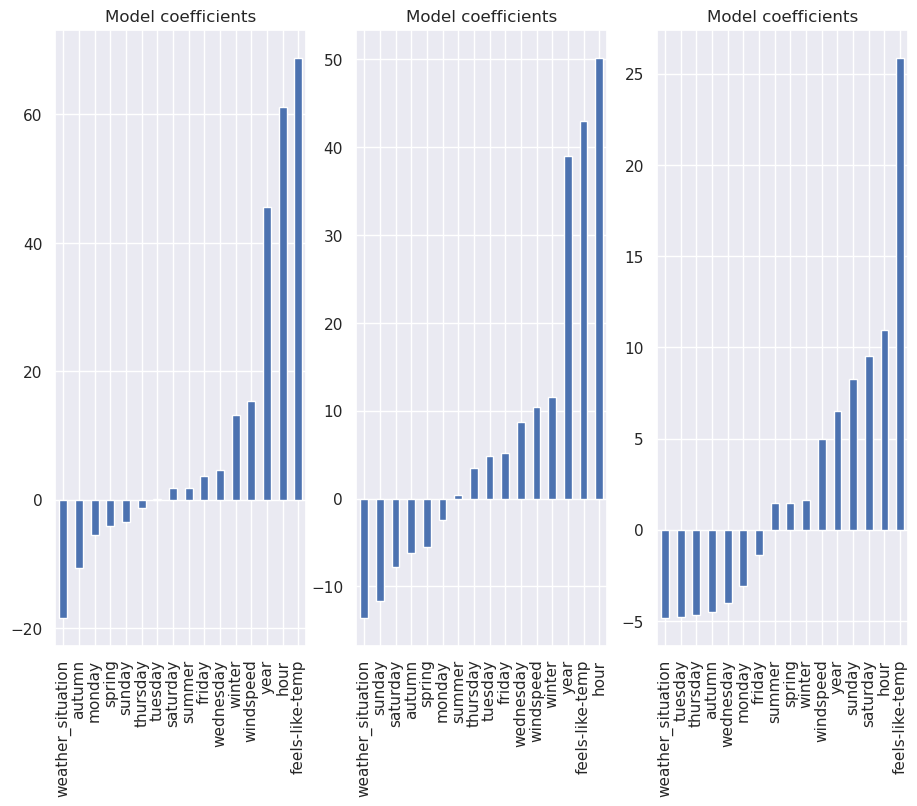

In [97]:
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytest.columns):

    col_values = ytest[col].values
    model.fit(xtest_scaled_df, col_values)

    predictors = xtest_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

Before I continue, I am happy to drop the very badly performing features above to try narrow down our search for the best predictors.

BIKE_COUNT 
 sunday             -1.504935
thursday            0.649138
friday              5.250001
wednesday           5.754931
winter             16.063935
windspeed          16.094330
year               45.823504
hour               61.799398
feels-like-temp    67.378056
dtype: float64 

REGISTERED 
 sunday             -9.355876
thursday            5.636942
friday              7.162449
wednesday          10.288062
windspeed          10.790938
winter             14.967246
year               39.173571
feels-like-temp    44.947873
hour               50.237774
dtype: float64 

CASUAL 
 thursday           -4.987804
wednesday          -4.533131
friday             -1.912448
winter              1.096690
windspeed           5.303392
year                6.649933
sunday              7.850942
hour               11.561624
feels-like-temp    22.430183
dtype: float64 



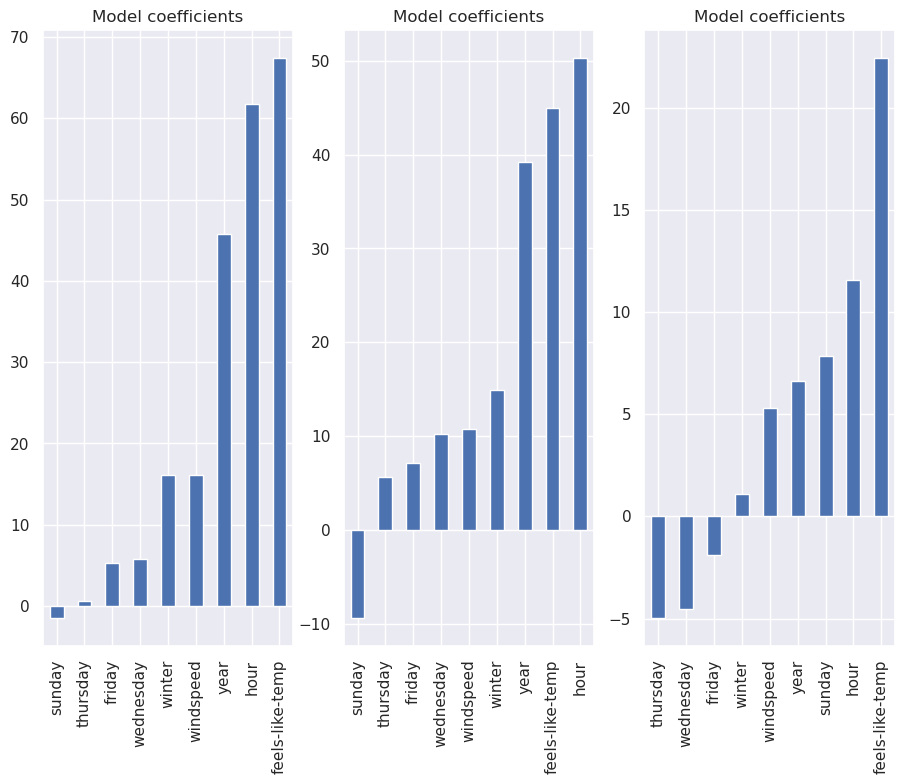

In [98]:
xtrain.drop(['weather_situation', 'autumn', 'spring', 'monday', 'tuesday', 'summer', 'saturday'], axis=1, inplace=True)
xtest.drop(['weather_situation', 'autumn', 'spring', 'monday', 'tuesday', 'summer', 'saturday'], axis=1, inplace=True)

# Transform the xtrain and xtest data using the scaler (fitting it to xtrain)
standard_scaler = StandardScaler()
xtrain_standard_scaled = standard_scaler.fit_transform(xtrain)
xtest_standard_scaled = standard_scaler.transform(xtest)

# Convert the scaled data back to dataframes
xtrain_scaled_df = pd.DataFrame(xtrain_standard_scaled, index=xtrain.index, columns=xtrain.columns)
xtest_scaled_df = pd.DataFrame(xtest_standard_scaled, index=xtest.index, columns=xtest.columns)


# Taking another look at the coef plot
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytest.columns):
    col_values = ytest[col].values
    model.fit(xtest_scaled_df, col_values)

    predictors = xtest_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

0.4775234002567454

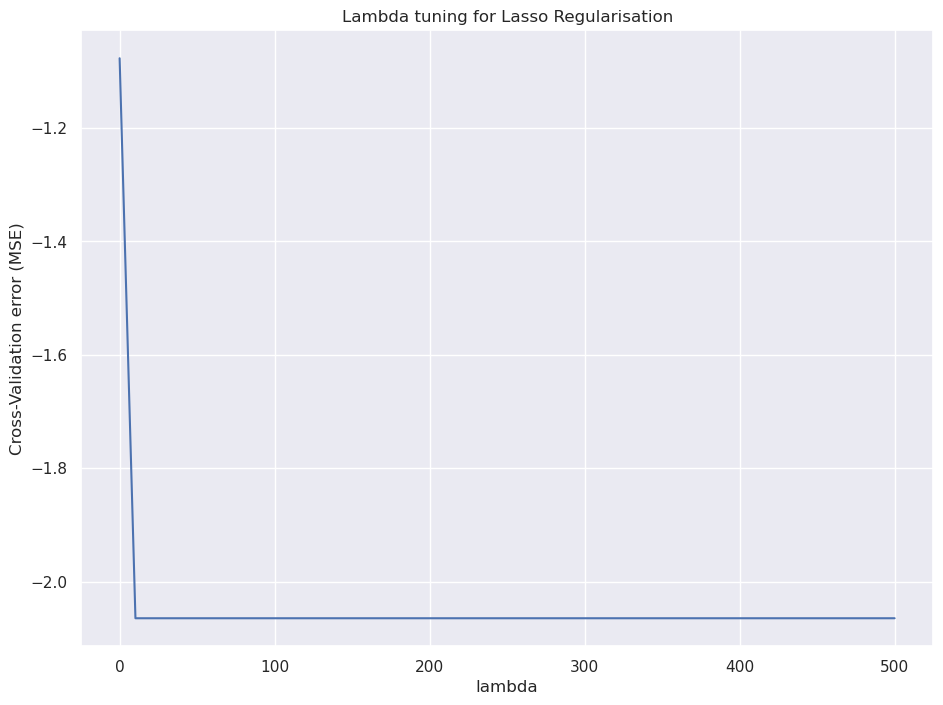

In [99]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso

lambdas = np.linspace(500,0.01,num=50) # Step 1
scoresCV = []
for l in lambdas:
    lassoReg = Lasso(alpha=l)
    lassoReg.fit(xtrain_scaled_df, ytrain)

    scoreCV = cross_val_score(lassoReg, xtrain_scaled_df, ytrain, scoring='neg_mean_squared_error',
                              cv=KFold(n_splits=10, shuffle=True,
                                       random_state=1))
    scoresCV.append(np.mean(scoreCV))

plt.title("Lambda tuning for Lasso Regularisation")
plt.xlabel("lambda")
plt.ylabel("Cross-Validation error (MSE)")

plt.plot(lambdas,scoresCV)

from sklearn.linear_model import MultiTaskLassoCV

lassoCV = MultiTaskLassoCV()
lassoCV.fit(xtrain_scaled_df, ytrain)

lassoCV.alpha_

lassoReg = Lasso(lassoCV.alpha_)
lassoReg.fit(xtrain_scaled_df, ytrain)
lassoReg.score(xtrain_scaled_df, ytrain)

#### Lasso Regression
We can now perform lasso regression to try deal with the last unwanted features.

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Create the lasso regression model
model = Lasso(alpha=0.1)

# Train the model on the training data
model.fit(xtrain_scaled_df, ytrain)

# Evaluate the model on the test data
y_pred = model.predict(xtest_scaled_df)

mse = mean_squared_error(ytest, y_pred)
mae = mean_absolute_error(ytest, y_pred)

coefs = model.coef_
coefs

array([[ 1.28420135e-01,  6.51379247e-01,  3.63930791e-01,
         3.09687265e-04,  3.15835884e-02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.42854056e-01,  6.52289740e-01,  2.97476883e-01,
         0.00000000e+00,  3.85622031e-02, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.24554471e-02,  5.28301701e-01,  6.60786385e-01,
         1.85725574e-02,  0.00000000e+00,  8.69340291e-02,
        -3.21873225e-02, -0.00000000e+00,  0.00000000e+00]])

We can now drop the unwanted features from our data set. We will keep

In [101]:
xtrain_scaled_df.drop(['sunday', 'wednesday', 'thursday', 'friday', 'windspeed', 'winter'], inplace=True, axis=1)
xtest_scaled_df.drop(['sunday', 'wednesday', 'thursday', 'friday', 'windspeed', 'winter'], inplace=True, axis=1)
xtrain.drop(['sunday', 'wednesday', 'thursday', 'friday', 'windspeed', 'winter'], inplace=True, axis=1)
xtest.drop(['sunday', 'wednesday', 'thursday', 'friday', 'windspeed', 'winter'], inplace=True, axis=1)

BIKE_COUNT 
 year               45.535901
feels-like-temp    62.601138
hour               64.487019
dtype: float64 

REGISTERED 
 year               38.867265
feels-like-temp    41.377355
hour               51.993515
dtype: float64 

CASUAL 
 year                6.571983
hour               12.403372
feels-like-temp    21.137633
dtype: float64 



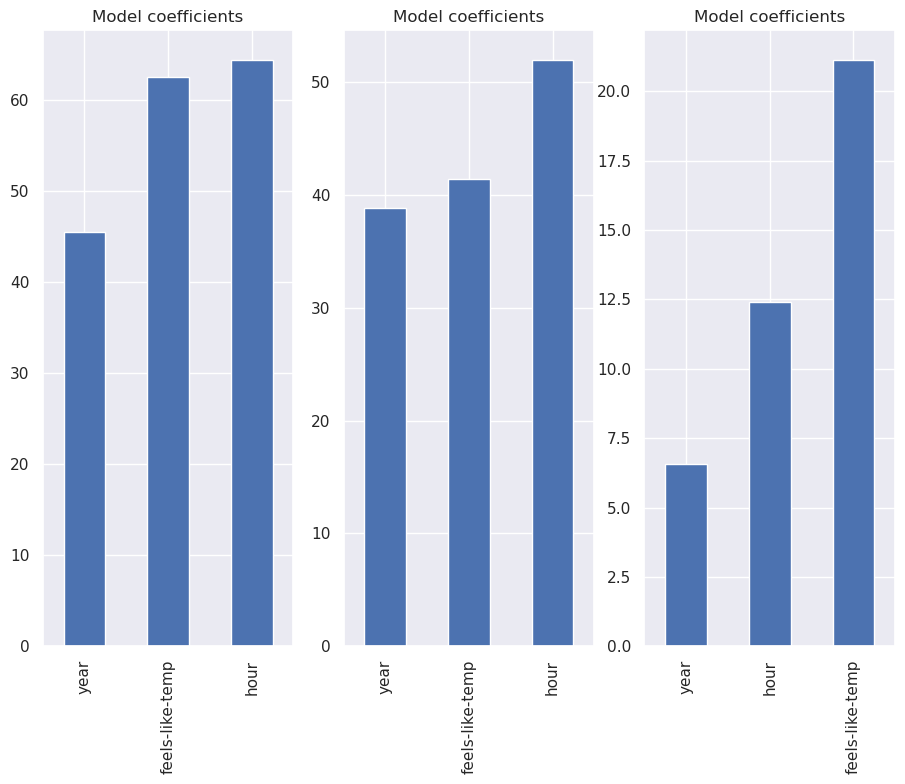

In [102]:
fig, ax = plt.subplots(1, 3)

# Using the enumerate() function to get the index and value of each column
for i, col in enumerate(ytest.columns):

    col_values = ytest[col].values
    model.fit(xtest_scaled_df, col_values)

    predictors = xtest_scaled_df.columns
    coef = pd.Series(model.coef_, predictors).sort_values()
    coef.plot(kind='bar', title="Model coefficients", ax=ax[i])
    print(col.upper(), "\n", coef, "\n")

We are left with the three predictors above, which as you can see are all great predictors!

### 10 Fold Cross Validation

0.4517515868094646

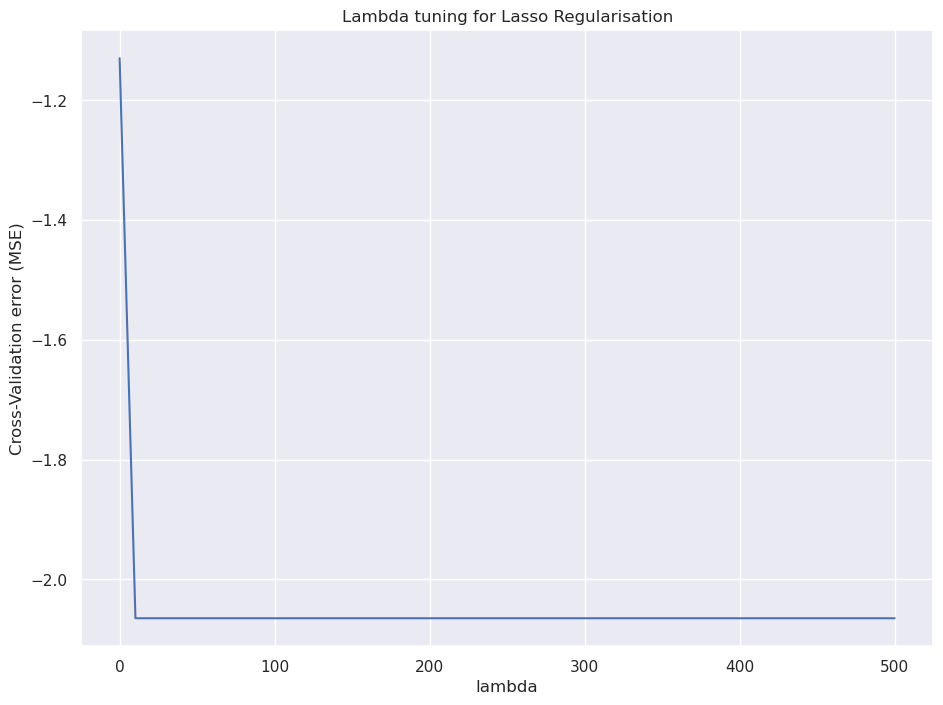

In [103]:
from sklearn.model_selection import cross_val_score, KFold

lambdas = np.linspace(500,0.01,num=50) # Step 1
scoresCV = []
for l in lambdas:
    lassoReg = Lasso(alpha=l)
    lassoReg.fit(xtrain_scaled_df, ytrain)

    scoreCV = cross_val_score(lassoReg, xtrain_scaled_df, ytrain, scoring='neg_mean_squared_error',
                              cv=KFold(n_splits=10, shuffle=True,
                                       random_state=1))
    scoresCV.append(np.mean(scoreCV))

plt.title("Lambda tuning for Lasso Regularisation")
plt.xlabel("lambda")
plt.ylabel("Cross-Validation error (MSE)")

plt.plot(lambdas,scoresCV)

from sklearn.linear_model import MultiTaskLassoCV

lassoCV = MultiTaskLassoCV()
lassoCV.fit(xtrain_scaled_df, ytrain)

lassoCV.alpha_

lassoReg = Lasso(lassoCV.alpha_)
lassoReg.fit(xtrain_scaled_df, ytrain)
lassoReg.score(xtrain_scaled_df, ytrain)

A 10-fold cross-validation value of 0.44117467290972723 indicates that the model's performance is relatively low on average, but the exact interpretation of this value will depend on the evaluation metric used and the context in which the model is being used. I may have taken some incorect steps, or chosen bad features. Maybe another scaling or regression type would have been better.

# Task 4: Which of the 3 target columns is easiest to predict accurately?

Of the three, it looks like casual is easiest to predict.

['hour', 'feels-like-temp', 'year']
[0, 0.31360650611289753, 0.40917358091564615, 0.4297173312658641]
['hour', 'feels-like-temp', 'year']
[0, 0.31590535146852405, 0.38606234623187463, 0.41062467430453486]
['feels-like-temp', 'hour', 'year']
[0, 0.30576063635523587, 0.4710089965311153, 0.47554534373053814]
['hour', 'feels-like-temp', 'year']
[0, 0.15449672939279302, 0.2745364215667504, 0.33632979186009926]
['hour', 'feels-like-temp', 'year']
[0, 0.13844534140135023, 0.21441664796387017, 0.27885219615536194]
['feels-like-temp', 'hour', 'year']
[0, 0.21348257932793258, 0.27527740757478814, 0.2932866224150722]


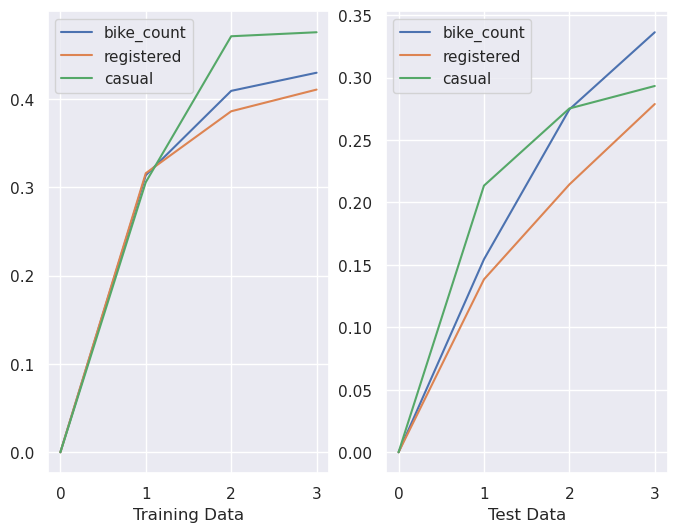

In [104]:
import matplotlib.pyplot as plt

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Loop over the columns in ytrain
for col in ytrain.columns:
    # Convert the column to a numeric array
    col_values = ytrain[col].values

    # Get the scores for the training data
    scores = predict_scores(xtrain_scaled_df, col_values)
    ax1.plot(scores, label=col)

# Loop over the columns in ytest
for col in ytest.columns:
    # Convert the column to a numeric array
    col_values = ytest[col].values

    # Get the scores for the test data
    scores = predict_scores(xtest_scaled_df, col_values)
    ax2.plot(scores, label=col)

# Set the labels and legends for the plots
ax1.set_xlabel('Training Data')
ax2.set_xlabel('Test Data')
ax1.legend()
ax2.legend()

# Show the figure
plt.show()


The above is interesting as the training data suggests that casual is easiest to predict while the test data suggests bike_count is easiest to predict. Since the test data represents a far larger portion of the data, it would make more sense to use that target instead so we will go with bike_count.

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

We can use pd.qcut() to split the bike_count target into four different quartiles to perform classification on it as seen below!

In [105]:
train_quartiles = pd.qcut(ytrain['bike_count'], 4, labels=False)
ytrain = ytrain.assign(count_quartiles = train_quartiles.values + 1)

test_quartiles = pd.qcut(ytest['bike_count'], 4, labels=False)
ytest = ytest.assign(count_quartiles = test_quartiles.values + 1)

ytest.head()

,bike_count,registered,casual,count_quartiles
10696,458,417,41,4
11252,13,11,2,1
1779,108,69,39,2
2553,198,183,15,3
11267,387,324,63,4


# Task 6: Use _two_ classification procedures to predict these demand quartiles
We will use K-Nearest Neighbours and Naive Bays as seen in the labs.

K nearest neighbors is a non-parametric method that is based on identifying the closest neighbors to a given data point and using those neighbors to make predictions about the data point. The algorithm is called "k" nearest neighbors because it considers the k closest neighbors to the data point when making predictions. This makes KNN a flexible and effective algorithm for a wide range of classification tasks.

Naive Bayes is a probabilistic method that is based on the Bayes theorem of probability. It is called "naive" because it assumes that all features are independent of each other, which is often not the case in real-world data. Despite this assumption, naive Bayes can still be a powerful and effective algorithm for classification tasks, especially when the data is well-separated and the features are independent.

KNN and naive Bayes are both simple and easy to understand algorithms that can provide good performance on many classification tasks. Comparing the two algorithms can help you understand the strengths and weaknesses of each algorithm and choose the best one for your specific problem.

In [107]:
xtrain.corr()

,year,hour,feels-like-temp
year,1.000000,-0.007235,0.041951
hour,-0.007235,1.000000,0.136893
feels-like-temp,0.041951,0.136893,1.000000


We can implement both classification methods manually, but there is no need to do this as scikit-learn provides modules for this.

Since the data has already been scaled as seen before we don't need to repeat this step. If regression hadn't been completed yet, usually you would scale before classification if applicable.

In [131]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Import the slearn utility to compare algorithms
from sklearn import model_selection

# Prepare an array with the 2 algorithms
models = []
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))

# Prepare the configuration to run the test
seed = 42
results = []
names = []
nSplits = 10

The above code sets up a configuration to compare the performance of the GaussianNB and KNeighborsClassifier algorithms and records the accuracy scores of each algorithm.

The below code evaluates the performance of the GaussianNB and KNeighborsClassifier algorithms on the training data and outputs the mean and standard deviation of their accuracy scores. The output shows the mean and standard deviation of the accuracy scores for the GaussianNB and KNeighborsClassifier algorithms. The GaussianNB algorithm achieved an average accuracy of 0.559878, with a standard deviation of 0.015380, while the KNeighborsClassifier algorithm achieved an average accuracy of 0.644394, with a standard deviation of 0.010769.

These results suggest that the KNeighborsClassifier algorithm performed better than the GaussianNB algorithm on the training data, with a higher average accuracy and a lower standard deviation. This suggests that the KNeighborsClassifier algorithm was more consistent in its performance and was better able to generalize to unseen data. However, it is important to note that these results are only based on the training data, and it would be necessary to evaluate the algorithms on the test set to determine their true performance.

In [132]:
# Fit the classifiers and output the crossVal results
for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed, shuffle=True)
    crossValResults = model_selection.cross_val_score(
        model, xtrain_scaled_df, np.ravel(ytrain['count_quartiles']), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.559878 (0.015380)
KNN: 0.644394 (0.010769)


The GaussianNB algorithm achieved an average accuracy of 0.565309, with a standard deviation of 0.009616, while the KNeighborsClassifier algorithm achieved an average accuracy of 0.661132, with a standard deviation of 0.025254.

These results suggest that the KNeighborsClassifier algorithm continued to perform better than the GaussianNB algorithm on the test data, with a higher average accuracy and a slightly higher standard deviation. This suggests that the KNeighborsClassifier algorithm was able to generalize better to unseen data and had a higher overall performance on the test set.

Overall, these results suggest that the KNeighborsClassifier algorithm is a better choice for this problem than the GaussianNB algorithm, as it achieved a higher accuracy on both the training and test data

In [133]:
# Fit the classifiers and output the crossVal results
for name, model in models:
    # We use k-fold cross validation, where 10% of the training data is held back each time
    kfold = model_selection.KFold(n_splits=nSplits, random_state=seed, shuffle=True)
    crossValResults = model_selection.cross_val_score(
        model, xtest_scaled_df, np.ravel(ytest['count_quartiles']), cv=kfold, scoring='accuracy')
    results.append(crossValResults)
    names.append(name)
    # Now print the results
    print("%s: %f (%f)" % (name, crossValResults.mean(), crossValResults.std()))

NB: 0.565309 (0.009616)
KNN: 0.661132 (0.025254)


Again, the below plot visualises the same result derived from the outputs above. We cam see that the KNN classifier performs significantly better in this problem in both train and test data.

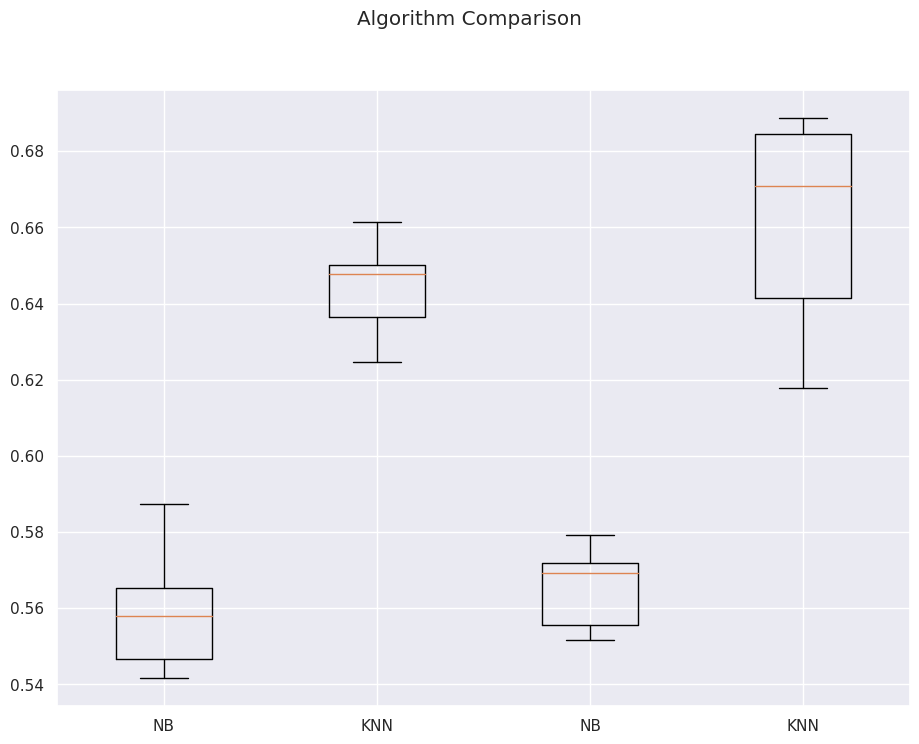

In [134]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The below function calculates and outputs various diagnostic metrics for a classification model, including accuracy, confusion matrix, and classification report. These metrics can be used to evaluate the performance of the model and diagnose any problems or issues with the predictions.

In [136]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def showDiagnostics(y, y_pred):
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",accuracy_score(y, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("Classification Report:")
    print(classification_report(y, y_pred, digits=3))

### Naive Bayes
Next we want to create a naive bayes classifier. The below code trains a GaussianNB classification model on the training data and evaluates its performance on the test data by calculating and outputting various diagnostic metrics.

In [123]:
# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(xtrain_scaled_df,np.ravel(ytrain['count_quartiles']))

# prediction on test set
y_pred=clf.predict(xtest_scaled_df)

showDiagnostics(ytest['count_quartiles'], y_pred)

Accuracy: 0.557825086306099
Confusion Matrix:
[[778  76  15   5]
 [300 338 175  52]
 [128 121 306 320]
 [117  21 207 517]]
Classification Report:
              precision    recall  f1-score   support

           1      0.588     0.890     0.708       874
           2      0.608     0.391     0.476       865
           3      0.435     0.350     0.388       875
           4      0.578     0.600     0.589       862

    accuracy                          0.558      3476
   macro avg      0.552     0.558     0.540      3476
weighted avg      0.552     0.558     0.540      3476



The output shows the accuracy, confusion matrix, and classification report for the GaussianNB model when evaluated on the test data. The model achieved an overall accuracy of 0.557825, which means that it correctly classified approximately 56% of the data. The confusion matrix shows the number of true positive, false positive, true negative, and false negative predictions for each class. For example, the model correctly classified 778 instances of class 1, but it also misclassified 76 instances of class 1 as belonging to another class.

The report also shows the precision, recall, and F1-score for each class. Precision is the fraction of true positive predictions among all positive predictions, while recall is the fraction of true positive predictions among all actual positive instances. The F1-score is the harmonic mean of precision and recall, and it provides a single score that takes both precision and recall into account. For example, the model had a precision of 0.588 for class 1, a recall of 0.890, and an F1-score of 0.708.

Overall, these results suggest that the GaussianNB model performed well on some classes but poorly on others. It had a relatively high accuracy and a high precision and recall for class 1, but it had a lower precision and recall for the other classes. This indicates that the model was able to identify instances of class 1 well, but it struggled to accurately classify instances of the other classes. These results could be improved by using a different classification algorithm or by fine-tuning the parameters of the GaussianNB model.

### K Nearest Neighbours
Next we want to create the KNN classifier. This code trains a KNeighborsClassifier classification model on the training data with 5 nearest neighbors and evaluates its performance on the test data by calculating and outputting various diagnostic metrics.

In [ ]:
# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets y_pred=clf.predict(xtest)
clf.fit(xtrain_scaled_df,np.ravel(ytrain['count_quartiles']))

# prediction on test set
y_pred=clf.predict(xtest_scaled_df)

showDiagnostics(ytest['count_quartiles'], y_pred)

The output shows the accuracy, confusion matrix, and classification report for the KNeighborsClassifier model when evaluated on the test data. The model achieved an overall accuracy of 0.662831, which means that it correctly classified approximately 66% of the data. The confusion matrix shows the number of true positive, false positive, true negative, and false negative predictions for each class. For example, the model correctly classified 702 instances of class 1, but it also misclassified 131 instances of class 1 as belonging to another class.

The classification report shows the precision, recall, and F1-score for each class. Precision is the fraction of true positive predictions among all positive predictions, while recall is the fraction of true positive predictions among all actual positive instances. The F1-score is the harmonic mean of precision and recall, and it provides a single score that takes both precision and recall into account. For example, the model had a precision of 0.823 for class 1, a recall of 0.803, and an F1-score of 0.813.

Overall, these results suggest that the KNeighborsClassifier model performed well on all classes compared to the GaussianNB model. It had a relatively high accuracy and a high precision and recall for all classes. This may indicate that the model was able to accurately classify instances of all classes. These results could be improved further by using a different number of nearest neighbors or by fine-tuning the parameters of the KNeighborsClassifier model.

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

In task 6, a GaussianNB and a KNeighborsClassifier model were trained on the bike sharing data to classify the target variable into four quartiles. The performance of the two models was evaluated on the test data using various diagnostic metrics such as accuracy, precision, recall, and F1-score.

Overall, the results showed that the KNeighborsClassifier model performed better than the GaussianNB model. It had a higher accuracy of 0.662831 compared to 0.557825 for the GaussianNB model. It also had a higher precision, recall, and F1-score for all classes, indicating that it was able to make more accurate predictions compared to the GaussianNB model.

Therefore, it can be concluded that the KNeighborsClassifier model is better suited for this data and task compared to the GaussianNB model. It is able to make more accurate predictions and has a higher overall performance.



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

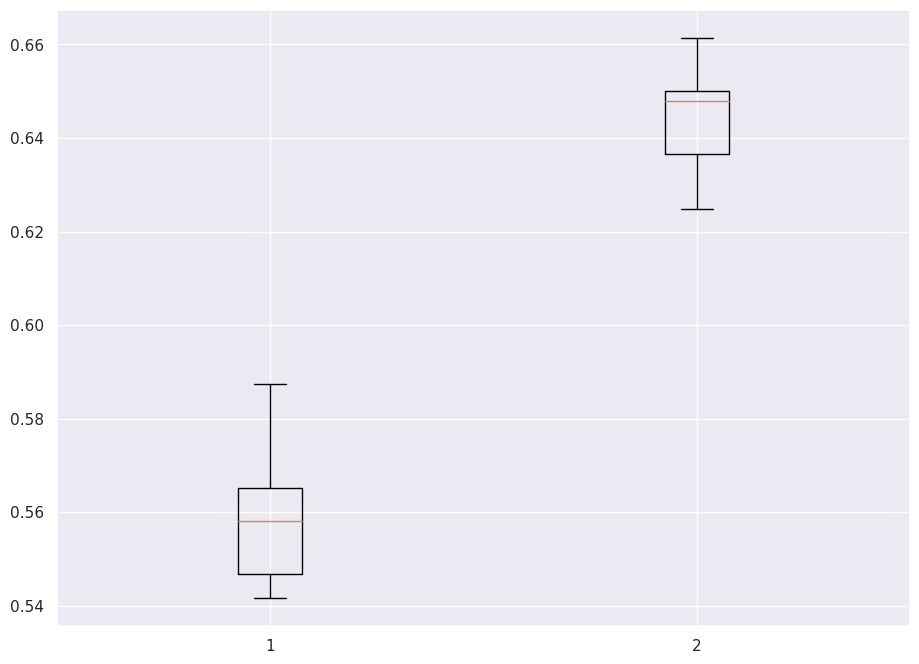

In [140]:
fig = plt.figure()

plt.boxplot([results[0], results[1]])

ax = plt.gca()
ax.set_xticklabels(names)

ax.set_xticks([0, 1, 2, 3])

plt.show()